# Gaussian Process Latent Variable Model

In a previous tutorial, we have discussed latent variable models, in particular probabilistic principal component analysis (pPCA).
Here, we show how we can extend the mapping provided by pPCA to non-linear mappings between input and output.
For more details about the Gaussian Process Latent Variable Model (GPLVM),
we refer the reader to the [original publication](https://jmlr.org/papers/v6/lawrence05a.html) and a [further extension](http://proceedings.mlr.press/v9/titsias10a/titsias10a.pdf).

In short, the GPVLM is a dimensionality reduction technique that allows us to embed a high-dimensional dataset in a lower-dimensional embedding.
Importantly, it provides the advantage that the linear mappings from the embedded space can be non-linearised through the use of Gaussian Processes.

Let's start by loading some dependencies.

In [6]:
using Turing
using AbstractGPs
using FillArrays
using LaTeXStrings
using Plots
using RDatasets
using ReverseDiff
using StatsBase

using LinearAlgebra
using Random

Random.seed!(1789);

We demonstrate the GPLVM with a very small dataset: [Fisher's Iris data set](https://en.wikipedia.org/wiki/Iris_flower_data_set).
This is mostly for reasons of run time, so the tutorial can be run quickly.
As you will see, one of the major drawbacks of using GPs is their speed,
although this is an active area of research.
We will briefly touch on some ways to speed things up at the end of this tutorial.
We transform the original data with non-linear operations in order to demonstrate the power of GPs to work on non-linear relationships, while keeping the problem reasonably small.

In [7]:
data = dataset("datasets", "iris")
species = data[!, "Species"]
index = shuffle(1:150)
# we extract the four measured quantities,
# so the dimension of the data is only d=4 for this toy example
dat = Matrix(data[index, 1:4])
labels = data[index, "Species"]

# non-linearize data to demonstrate ability of GPs to deal with non-linearity
dat[:, 1] = 0.5 * dat[:, 1] .^ 2 + 0.1 * dat[:, 1] .^ 3
dat[:, 2] = dat[:, 2] .^ 3 + 0.2 * dat[:, 2] .^ 4
dat[:, 3] = 0.1 * exp.(dat[:, 3]) - 0.2 * dat[:, 3] .^ 2
dat[:, 4] = 0.5 * log.(dat[:, 4]) .^ 2 + 0.01 * dat[:, 3] .^ 5

# normalize data
dt = fit(ZScoreTransform, dat; dims=1);
StatsBase.transform!(dt, dat);

We will start out by demonstrating the basic similarity between pPCA (see the tutorial on this topic) and the GPLVM model.
Indeed, pPCA is basically equivalent to running the GPLVM model with an automatic relevance determination (ARD) linear kernel.

First, we re-introduce the pPCA model (see the tutorial on pPCA for details)

In [8]:
@model function pPCA(x)
    # Dimensionality of the problem.
    N, D = size(x)
    # latent variable z
    z ~ filldist(Normal(), D, N)
    # weights/loadings W
    w ~ filldist(Normal(), D, D)
    mu = (w * z)'
    for d in 1:D
        x[:, d] ~ MvNormal(mu[:, d], I)
    end
    return nothing
end;

We define two different kernels, a simple linear kernel with an Automatic Relevance Determination transform and a
squared exponential kernel.

In [9]:
linear_kernel(α) = LinearKernel() ∘ ARDTransform(α)
sekernel(α, σ) = σ * SqExponentialKernel() ∘ ARDTransform(α);

And here is the GPLVM model.
We create separate models for the two types of kernel.

In [10]:
@model function GPLVM_linear(Y, K)
    # Dimensionality of the problem.
    N, D = size(Y)
    # K is the dimension of the latent space
    @assert K <= D
    noise = 1e-3

    # Priors
    α ~ MvLogNormal(MvNormal(Zeros(K), I))
    Z ~ filldist(Normal(), K, N)
    mu ~ filldist(Normal(), N)

    gp = GP(linear_kernel(α))
    gpz = gp(ColVecs(Z), noise)
    Y ~ filldist(MvNormal(mu, cov(gpz)), D)

    return nothing
end;

@model function GPLVM(Y, K)
    # Dimensionality of the problem.
    N, D = size(Y)
    # K is the dimension of the latent space
    @assert K <= D
    noise = 1e-3

    # Priors
    α ~ MvLogNormal(MvNormal(Zeros(K), I))
    σ ~ LogNormal(0.0, 1.0)
    Z ~ filldist(Normal(), K, N)
    mu ~ filldist(Normal(), N)

    gp = GP(sekernel(α, σ))
    gpz = gp(ColVecs(Z), noise)
    Y ~ filldist(MvNormal(mu, cov(gpz)), D)

    return nothing
end;

In [11]:
# Standard GPs don't scale very well in n, so we use a small subsample for the purpose of this tutorial
n_data = 40
# number of features to use from dataset
n_features = 4
# latent dimension for GP case
ndim = 4;

In [12]:
ppca = pPCA(dat[1:n_data, 1:n_features])
chain_ppca = sample(ppca, NUTS{Turing.ReverseDiffAD{true}}(), 1000);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference C:\Users\olarinoyem\.julia\packages\Turing\b6CoW\src\inference\hmc.jl:190
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


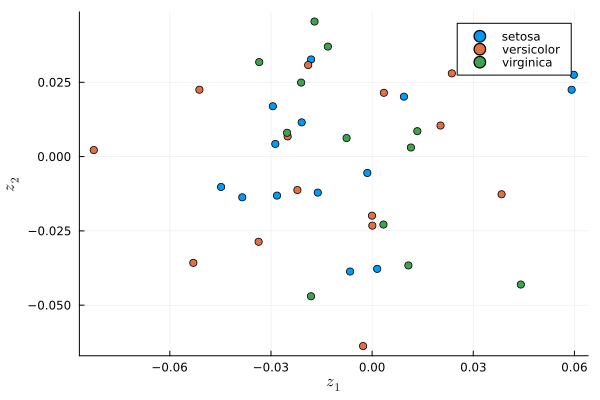

In [13]:
# we extract the posterior mean estimates of the parameters from the chain
z_mean = reshape(mean(group(chain_ppca, :z))[:, 2], (n_features, n_data))
scatter(z_mean[1, :], z_mean[2, :]; group=labels[1:n_data], xlabel=L"z_1", ylabel=L"z_2")

We can see that the pPCA fails to distinguish the groups.
In particular, the `setosa` species is not clearly separated from `versicolor` and `virginica`.
This is due to the non-linearities that we introduced, as without them the two groups can be clearly distinguished
using pPCA (see the pPCA tutorial).

Let's try the same with our linear kernel GPLVM model.

In [14]:
gplvm_linear = GPLVM_linear(dat[1:n_data, 1:n_features], ndim)
chain_linear = sample(gplvm_linear, NUTS{Turing.ReverseDiffAD{true}}(), 500);

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference C:\Users\olarinoyem\.julia\packages\Turing\b6CoW\src\inference\hmc.jl:190
Sampling: 100%|█████████████████████████████████████████| Time: 0:38:36


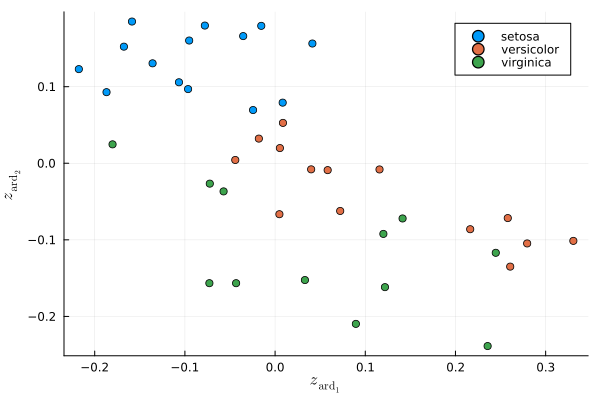

In [15]:
# we extract the posterior mean estimates of the parameters from the chain
z_mean = reshape(mean(group(chain_linear, :Z))[:, 2], (n_features, n_data))
alpha_mean = mean(group(chain_linear, :α))[:, 2]

alpha1, alpha2 = partialsortperm(alpha_mean, 1:2; rev=true)
scatter(
    z_mean[alpha1, :],
    z_mean[alpha2, :];
    group=labels[1:n_data],
    xlabel=L"z_{\mathrm{ard}_1}",
    ylabel=L"z_{\mathrm{ard}_2}",
)

We can see that similar to the pPCA case, the linear kernel GPLVM fails to distinguish between the two groups
(`setosa` on the one hand, and `virginica` and `verticolor` on the other).

Finally, we demonstrate that by changing the kernel to a non-linear function, we are able to separate the data again.

In [16]:
gplvm = GPLVM(dat[1:n_data, 1:n_features], ndim)
chain_gplvm = sample(gplvm, NUTS{Turing.ReverseDiffAD{true}}(), 500);

┌ Info: Found initial step size
│   ϵ = 0.049218750000000006
└ @ Turing.Inference C:\Users\olarinoyem\.julia\packages\Turing\b6CoW\src\inference\hmc.jl:190
Sampling: 100%|█████████████████████████████████████████| Time: 0:16:52


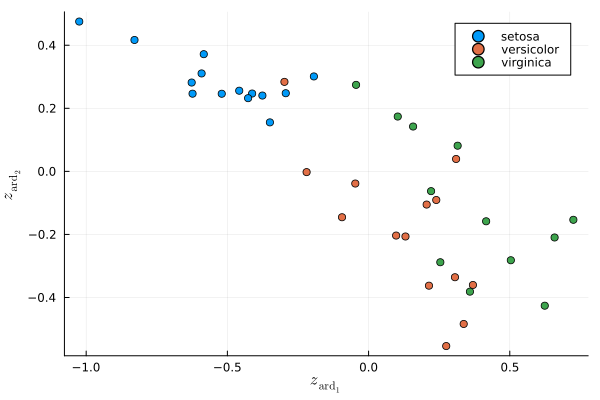

In [17]:
# we extract the posterior mean estimates of the parameters from the chain
z_mean = reshape(mean(group(chain_gplvm, :Z))[:, 2], (ndim, n_data))
alpha_mean = mean(group(chain_gplvm, :α))[:, 2]

alpha1, alpha2 = partialsortperm(alpha_mean, 1:2; rev=true)
scatter(
    z_mean[alpha1, :],
    z_mean[alpha2, :];
    group=labels[1:n_data],
    xlabel=L"z_{\mathrm{ard}_1}",
    ylabel=L"z_{\mathrm{ard}_2}",
)

In [19]:
let
    @assert abs(
        mean(z_mean[alpha1, labels[1:n_data] .== "setosa"]) -
        mean(z_mean[alpha1, labels[1:n_data] .!= "setosa"]),
    ) > 1
end

LoadError: AssertionError: abs(mean(z_mean[alpha1, labels[1:n_data] .== "setosa"]) - mean(z_mean[alpha1, labels[1:n_data] .!= "setosa"])) > 1

Now, the split between the two groups is visible again.

In [20]:
if isdefined(Main, :TuringTutorials)
    Main.TuringTutorials.tutorial_footer(WEAVE_ARGS[:folder], WEAVE_ARGS[:file])
end